Training Variational Autoencoder with Multiple Lock-In Data

We will use asymmetrical encoder-decoder archetecture

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [1]:
# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
sess = tf.Session(config = tf.ConfigProto(log_device_placement = True))

import keras
keras.backend.set_session(sess)

Using TensorFlow backend.


We wrap the machine learning process into functions:

1) DataPrep(filepath, test_ratio, z_cut) : takes the AFM measurement data in .npz format and returns rawdata, training set and the validation set

2) CreateVAE(** hyperparameters) : creates the VAE model given the hyperparameters of the model

3) SaveModel(savepath) : saves the training results in a suitable format

In [2]:
'''
** Dataprep(filepath, test_ratio, z_cut) **
Inputs:
- filepath: path to the pre-processed AFM data file, in .npz format
- test_ratio: the ratio between the total number of approach curve data and the number of the approach curve data used in the validation set
- z_cut: the z point at after which the AFM data is truncated and tossed


Outputs:
- train_dataset: dataset corresponding to the training set
- test_dataset: dataset corresponding to the test set
- train: training set
- test: test set
'''

def DataPrep(filepath, test_ratio = 0.1, z_cut = 5, n_deriv = 1): # the filepath must point to pre-processed AFM datafile, in .npz format
    # load the npz file
    dataset = np.load(filepath, allow_pickle=True)

    raw_dataset = dataset['raw'] # Lock-in raw data, [z, Amp(V), Phas(rad)] format
    mech_dataset = dataset['mech'] # Mechanical Amp, Phas,[z, Amp(V), Phas(rad)] format
    imin_dataset = dataset['imin'] # array index of the turning point : Appoach is from 0 ~ imin, Retract is from imin ~ end

    # Resonance curve fitting parameters
    Q_dataset = dataset['Q']
    w_dataset = dataset['w']
    w0_dataset = dataset['w0']
    I0_dataset = dataset['I0']
    C0C_dataset = dataset['C0C']

    E_dataset = dataset['E'] # Dissipated energy, normalized by kA0^2
    kint_dataset = dataset['kint'] # k_int, normalized by k
    bint_dataset = dataset['bint'] # b_int, normalized by k

    Fk_dataset = dataset['Fk'] # <F_k> = kA, normalized by kA0
    Fb_dataset = dataset['Fb'] # <F_b> = bwA, normalized by kA0

    filename_dataset = dataset['filename'] # filename

    N = Q_dataset.size
    N_test = int(N*test_ratio)

    print('Number of test samples : %d' %(N_test))
    print('Number of training samples : %d' %(N - N_test))

    sample_index = np.arange(N)
    np.random.shuffle(sample_index) # shuffle the input data

    train = np.empty([1,5+2*n_deriv]) # z, amp, phas, w/w0, Q
    test = np.empty([1,5+2*n_deriv]) 
    train_dataset = []
    test_dataset = []
    
    for i in range(N):
        index = sample_index[i]
    
        imin = imin_dataset[index]
        ww0_array = np.ones((imin, 1))*w_dataset[index]/w0_dataset[index] # Array of w/w0
        Q_array = np.ones((imin, 1))*Q_dataset[index]
        
        mech_dataset[index][:, 1] = mech_dataset[index][:, 1]/mech_dataset[index][0, 1] # Normalize the mechanical amplitude
        
        data = np.c_[mech_dataset[index][0:imin, :], ww0_array, Q_array]
        
        # Truncate the data for z > z_cut
        z = raw_dataset[index][0:imin, 0]
        cut_index = z < z_cut
        data = data[cut_index, :]
        
        if i < N_test:   
            test = np.r_[test, data]
        else:
            train = np.r_[train, data]

    test = test[1:, :] # Discard the first row, which is randomly initialized by np.empty
    train = train[1:, :]
    
    test_index = sample_index[0:N_test]
    train_index = sample_index[N_test:]
    
    keys = np.array(list(dataset.keys()))
    values = np.array(list(dataset.values()))
    print(values.shape)
    
    train_dataset = dict(zip(keys, values[:, train_index]))
    test_dataset = dict(zip(keys, values[:, test_index]))
    
    return [train_dataset, test_dataset, train, test]

In [7]:
from keras.models import Model
from keras import metrics
from keras import backend as K
K.clear_session()

from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, Lambda, Concatenate


In [8]:
''' 
** CreateVAE(** hyperparameters)
Inputs:
- n_hidden: number of hidden layers
- n_node: number of nodes per hidden layer
- dropout_rate
- batch_normalization: True or False
- activation: activation function of the hidden layer; 'relu', 'elu', ...
- optimizer: 'adam', 'rmsprop', ...

Outputs:
- Keras model of the created VAE in the form [model, encoder, decoder]

<References>
1) https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder
2) https://keras.io/examples/variational_autoencoder/
3) https://blog.keras.io/building-autoencoders-in-keras.html
4) https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py
'''

# Wrap the model into a function which takes the hyperparameters as input
def CreateVAE(n_deriv = 1, n_hidden = 3, n_node = 64, dropout_rate = 0.2, batch_normalization = True, activation = 'relu', optimizer = 'adam'):
    
    # Number of nodes
    input_sequence_dim = 2*(n_deriv+1) # Dimension of the sequential data; currently consists of (amp, phas, amp', phas')
    input_scalar_dim = 2 # Dimension of the discrete scalar data; currently consists of (Q, w/w0)
    intermediate_dim = n_node
    latent_dim = 1

    # Note that batch normalization needs to be applied after the linear operation, but before the nonlinear activation.
    # Dropout is applied after the activation
    
    # First, define the inputs
    input_sequence = Input(shape = (input_sequence_dim, ), name = 'Sequence_Input')
    input_scalar = Input(shape = (input_scalar_dim, ), name = 'Scalar_Input')
    
    # Encoder archetecture
    encoder_input = Concatenate(name = 'encoder_input')([input_sequence, input_scalar])
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=False)(encoder_input)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    for i in range(n_hidden):
        x = Dense(intermediate_dim)(x)
        if batch_normalization:
            x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=False)(x)
        x = Activation(activation)(x)
        x = Dropout(dropout_rate)(x)

    z_mean = Dense(latent_dim, name = 'z_mean')(x)
    z_log_var = Dense(latent_dim, name = 'z_log_var')(x)
    
    # sampling function
    def sampling(args): 
        '''
        Arguments:
        args (tensor): mean and lof of variance of Q(z|X)
    
        Returns:
        z(tensor): sampled latent vector
        '''
        z_mean, z_log_var = args # note that z_log_var instead of z_log_std is used. This is a trick that speeds up convergence
        
        return z_mean + K.exp(0.5 * z_log_var) * K.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1])) 
    
    # sample vector from the latent distribution
    z = Lambda(sampling, output_shape = (latent_dim, ), name = 'z')([z_mean, z_log_var])
    
    # decoder takes the latent distribution sample as input
    latent_vector = Input(shape = (latent_dim, ), name = 'z_sampling')
    decoder_input = Concatenate()([latent_vector, input_scalar])
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=False)(decoder_input)
    x = Activation(activation)(x)
    x = Dropout(dropout_rate)(x)

    for i in range(n_hidden):
        x = Dense(intermediate_dim)(x)
        if batch_normalization:
            x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=False)(x)
        x = Activation(activation)(x)
        x = Dropout(dropout_rate)(x)


    output_layer = Dense(input_sequence_dim)(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=False)(x)
    x = Activation('tanh')(x)
    
    # encoder model statement
    encoder = Model([input_sequence, input_scalar], [z_mean, z_log_var, z], name = 'encoder')
    encoder.summary()
    #plot_model(encoder, to_file = 'vae_mlp_encoder.png', show_shapes = True)

    # decoder model statement
    decoder = Model([latent_vector, input_scalar], output_layer, name = 'decoder')
    decoder.summary()
    #plot_model(decoder, to_file = 'vae_mlp_decoder.png', show_shapes = True)

    # VAE model statement
    output_layer = decoder([encoder([input_sequence, input_scalar])[2], input_scalar])
    vae = Model([input_sequence, input_scalar], output_layer, name = 'vae')
    
    # Reconstruction loss
    reconstruction_loss = input_sequence_dim * keras.losses.mse(input_sequence, output_layer)

    # KL divergence
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    
    vae_loss = K.mean(10*reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    vae.compile(optimizer = optimizer)
    vae.summary()

    return {'model':vae, 'encoder':encoder, 'decoder':decoder} # To return multiple outputs, including the model, need to wrap in a dictionary



Number of test samples : 31
Number of training samples : 279
(14, 310)


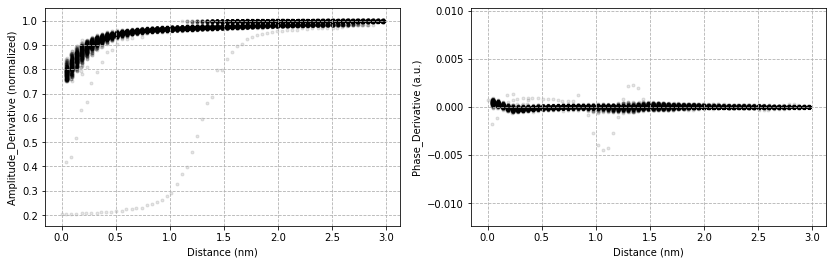

In [3]:
# filepath to the reformatted data file
filepath = '/home/jhko725/Projects/Jhe_Lab/CP_Detection/AFM_CP_Detection/Raw_Data/DohyunBest_deriv3.npz'
test_ratio = 0.1
z_cut = 3

train_dataset, test_dataset, train, test = DataPrep(filepath, test_ratio, z_cut, n_deriv = 2)

# Graph the training set
fig = plt.figure(figsize = (14, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
kwargs = {'c':'k', 'marker':'.', 'alpha':0.1}

ax1.scatter(train[:,0], train[:, 1], **kwargs)
ax1.set_xlabel('Distance (nm)')
ax1.set_ylabel('Amplitude_Derivative (normalized)')
ax1.grid(ls = '--')

ax2.scatter(train[:,0], train[:, 6], **kwargs)
ax2.set_xlabel('Distance (nm)')
ax2.set_ylabel('Phase_Derivative (a.u.)')
ax2.grid(ls = '--')


Text(0.5, 1.0, 'Phase space of the Training dataset (colormap = z)')

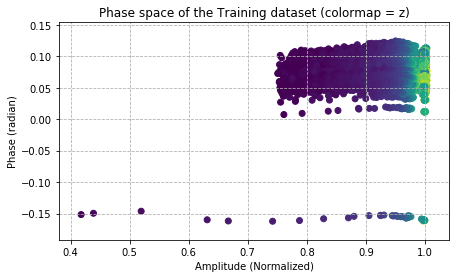

In [6]:
fig = plt.figure(figsize = (7, 4))
ax = fig.add_subplot(111)

ax.scatter(train[:,1], train[:,2], c = train[:,0])
ax.grid(ls = '--')
ax.set_xlabel('Amplitude (Normalized)')
ax.set_ylabel('Phase (radian)')
ax.set_title('Phase space of the Training dataset (colormap = z)')

In [23]:
from keras import optimizers
optimizer = optimizers.Adam(lr = 1e-4)

vae = CreateVAE(n_deriv = 2, n_hidden = 5, n_node = 64, dropout_rate = 0.0, optimizer = optimizer)

model = vae['model']
encoder = vae['encoder']
batch_size = 128

from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 6)            0                                            
__________________________________________________________________________________________________
Scalar_Input (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
encoder_input (Concatenate)     (None, 8)            0           Sequence_Input[0][0]             
                                                                 Scalar_Input[0][0]               
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 8)            24          encoder_input[0][0]              
__________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence_Input (InputLayer)     (None, 6)            0                                            
__________________________________________________________________________________________________
Scalar_Input (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 1), (None, 1 18330       Sequence_Input[0][0]             
                                                                 Scalar_Input[0][0]               
__________________________________________________________________________________________________
decoder (Model)                 (None, 6)            18255       encoder[1][2]                    
          

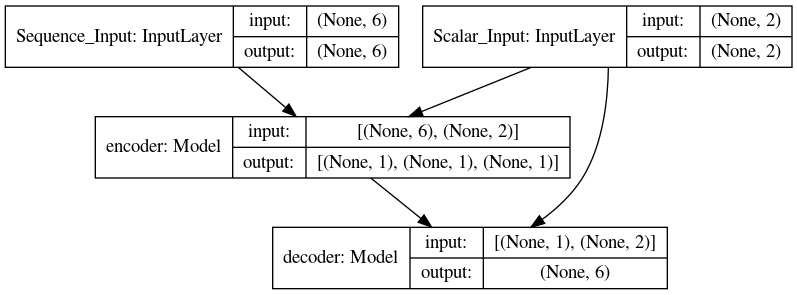

In [10]:
from IPython.display import Image
Image(filename='model_plot.png') 

In [24]:
from keras.callbacks import EarlyStopping
'''
Early stopping: stops the model if certain conditions are satisfied
References:
1) https://keras.io/callbacks/
2) https://stackoverflow.com/questions/53478622/stop-keras-training-when-the-network-has-fully-converge
'''
#stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 500, patience = 5) # loss change of under min_delta count as no improvement
#history = model.fit(x = train[:, 1:], epochs = 100, batch_size = batch_size, validation_data = (test[:, 1:], None), callbacks = [stop_callback])

history = model.fit(x = [train[:, 1:7],train[:, 7:]], epochs = 700, batch_size = batch_size, validation_data = ([test[:, 1:7], test[:, 7:]], None))


Train on 17846 samples, validate on 1984 samples
Epoch 1/700
17846/17846 [==============================] - 3s 164us/step - loss: 14.1609 - val_loss: 3.9496
Epoch 2/700
17846/17846 [==============================] - 1s 39us/step - loss: 2.5436 - val_loss: 1.3600
Epoch 3/700
17846/17846 [==============================] - 1s 39us/step - loss: 1.3794 - val_loss: 0.8222
Epoch 4/700
17846/17846 [==============================] - 1s 40us/step - loss: 1.0022 - val_loss: 0.6025
Epoch 5/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.8243 - val_loss: 0.4777
Epoch 6/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.7113 - val_loss: 0.4184
Epoch 7/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.5951 - val_loss: 0.3430
Epoch 8/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.5233 - val_loss: 0.3107
Epoch 9/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.4747 - val_loss: 0.

17846/17846 [==============================] - 1s 39us/step - loss: 0.0764 - val_loss: 0.1627
Epoch 78/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0751 - val_loss: 0.1598
Epoch 79/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0747 - val_loss: 0.1581
Epoch 80/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0754 - val_loss: 0.1575
Epoch 81/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0737 - val_loss: 0.1592
Epoch 82/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0739 - val_loss: 0.1584
Epoch 83/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0728 - val_loss: 0.1588
Epoch 84/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0729 - val_loss: 0.1631
Epoch 85/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0723 - val_loss: 0.1636
Epoch 86/700
17846/17846 [========================

17846/17846 [==============================] - 1s 39us/step - loss: 0.0603 - val_loss: 0.1536
Epoch 154/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0603 - val_loss: 0.1537
Epoch 155/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0607 - val_loss: 0.1541
Epoch 156/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0605 - val_loss: 0.1526
Epoch 157/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0611 - val_loss: 0.1519
Epoch 158/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0604 - val_loss: 0.1549
Epoch 159/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0601 - val_loss: 0.1551
Epoch 160/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0598 - val_loss: 0.1567
Epoch 161/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0599 - val_loss: 0.1533
Epoch 162/700
17846/17846 [===============

Epoch 229/700
17846/17846 [==============================] - 1s 42us/step - loss: 0.0575 - val_loss: 0.1546
Epoch 230/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0572 - val_loss: 0.1540
Epoch 231/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0574 - val_loss: 0.1576
Epoch 232/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0572 - val_loss: 0.1522
Epoch 233/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0572 - val_loss: 0.1531
Epoch 234/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0576 - val_loss: 0.1548
Epoch 235/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0572 - val_loss: 0.1511
Epoch 236/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0572 - val_loss: 0.1539
Epoch 237/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0574 - val_loss: 0.1553
Epoch 238/700
17846/17846 [=

Epoch 305/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0565 - val_loss: 0.1535
Epoch 306/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0562 - val_loss: 0.1521
Epoch 307/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0563 - val_loss: 0.1535
Epoch 308/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0561 - val_loss: 0.1559
Epoch 309/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0568 - val_loss: 0.1531
Epoch 310/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0560 - val_loss: 0.1506
Epoch 311/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0564 - val_loss: 0.1569
Epoch 312/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0562 - val_loss: 0.1522
Epoch 313/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0565 - val_loss: 0.1537
Epoch 314/700
17846/17846 [=

Epoch 381/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0555 - val_loss: 0.1534
Epoch 382/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0557 - val_loss: 0.1513
Epoch 383/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0556 - val_loss: 0.1525
Epoch 384/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0554 - val_loss: 0.1515
Epoch 385/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0556 - val_loss: 0.1530
Epoch 386/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0554 - val_loss: 0.1535
Epoch 387/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0556 - val_loss: 0.1537
Epoch 388/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0554 - val_loss: 0.1543
Epoch 389/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0555 - val_loss: 0.1543
Epoch 390/700
17846/17846 [=

Epoch 457/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0553 - val_loss: 0.1526
Epoch 458/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0554 - val_loss: 0.1519
Epoch 459/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0556 - val_loss: 0.1531
Epoch 460/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0552 - val_loss: 0.1539
Epoch 461/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0552 - val_loss: 0.1570
Epoch 462/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0550 - val_loss: 0.1541
Epoch 463/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0551 - val_loss: 0.1549
Epoch 464/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0551 - val_loss: 0.1526
Epoch 465/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0550 - val_loss: 0.1537
Epoch 466/700
17846/17846 [=

Epoch 533/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0549 - val_loss: 0.1541
Epoch 534/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0548 - val_loss: 0.1536
Epoch 535/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0548 - val_loss: 0.1529
Epoch 536/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0549 - val_loss: 0.1529
Epoch 537/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0549 - val_loss: 0.1522
Epoch 538/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0546 - val_loss: 0.1516
Epoch 539/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0548 - val_loss: 0.1522
Epoch 540/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0549 - val_loss: 0.1536
Epoch 541/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0547 - val_loss: 0.1536
Epoch 542/700
17846/17846 [=

Epoch 609/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0545 - val_loss: 0.1534
Epoch 610/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0547 - val_loss: 0.1529
Epoch 611/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0547 - val_loss: 0.1521
Epoch 612/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0546 - val_loss: 0.1555
Epoch 613/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0547 - val_loss: 0.1542
Epoch 614/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0548 - val_loss: 0.1515
Epoch 615/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0545 - val_loss: 0.1536
Epoch 616/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0548 - val_loss: 0.1515
Epoch 617/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0546 - val_loss: 0.1527
Epoch 618/700
17846/17846 [=

Epoch 685/700
17846/17846 [==============================] - 1s 41us/step - loss: 0.0546 - val_loss: 0.1533
Epoch 686/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0543 - val_loss: 0.1526
Epoch 687/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0549 - val_loss: 0.1515
Epoch 688/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0546 - val_loss: 0.1539
Epoch 689/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0547 - val_loss: 0.1515
Epoch 690/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0545 - val_loss: 0.1538
Epoch 691/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0544 - val_loss: 0.1522
Epoch 692/700
17846/17846 [==============================] - 1s 40us/step - loss: 0.0545 - val_loss: 0.1523
Epoch 693/700
17846/17846 [==============================] - 1s 39us/step - loss: 0.0547 - val_loss: 0.1519
Epoch 694/700
17846/17846 [=

Text(0.5, 0, 'Epoch')

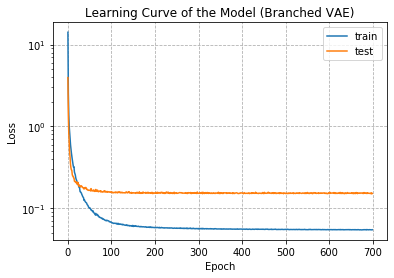

In [25]:
fig, ax = plt.subplots(1,1)
ax.plot(model.history.history['loss'])
ax.plot(model.history.history['val_loss'])
ax.legend(['train', 'test'], loc='upper right')
ax.set_yscale('log')
ax.grid(ls = '--')
plt.title('Learning Curve of the Model (Branched VAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')


**Analyze the trained results**

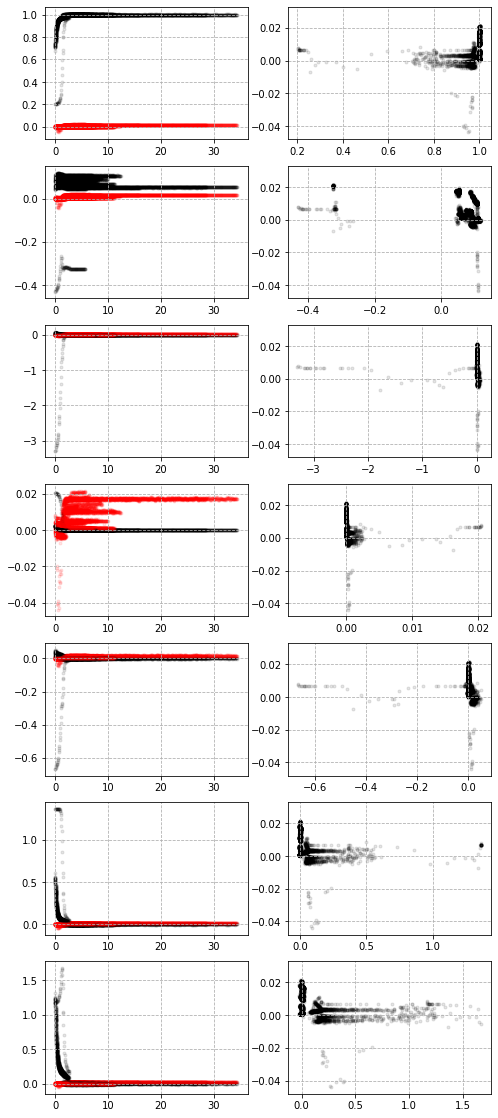

In [23]:
fig, axes = plt.subplots(7, 2, figsize = (8,20))
axes = axes.flatten()

for i in range(test_dataset['Q'].size):
    imin = test_dataset['imin'][i]
    plot_index = range(imin+1)
    
    mech = test_dataset['mech'][i][plot_index, :]
    k = test_dataset['kint'][i][plot_index]
    b = test_dataset['bint'][i][plot_index]
    E = test_dataset['E'][i][plot_index]
    Fk = test_dataset['Fk'][i][plot_index]
    Fb = test_dataset['Fb'][i][plot_index]

    ww0 = np.ones((imin+1, 1))*test_dataset['w'][i]/test_dataset['w0'][i]
    Q = np.ones((imin+1, 1))*test_dataset['Q'][i]
    
    #latent = encoder.predict(mech[:, 1:], batch_size = batch_size)
    latent = encoder.predict([mech[:, 1:], np.c_[ww0,Q]], batch_size = batch_size)
    
    axes[0].scatter(mech[:,0], mech[:,1], c = 'k', marker = '.', alpha = 0.1) # plot amplitude
    axes[0].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[1].scatter(mech[:,1], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[1].plot(latent[0], latent[0], '--r')
    
    
    axes[2].scatter(mech[:,0], mech[:,2], c = 'k', marker = '.', alpha = 0.1) # plot phase
    axes[2].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[3].scatter(mech[:,2], latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[3].plot(latent[0], latent[0], '--r')
    
    
    axes[4].scatter(mech[:,0], 10000*k, c = 'k', marker = '.', alpha = 0.1) # plot k
    axes[4].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[5].scatter(10000*k, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[5].plot(latent[0], latent[0], '--r')
    
    
    axes[6].scatter(mech[:,0], 1000000*b, c = 'k', marker = '.', alpha = 0.1) # plot b
    axes[6].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[7].scatter(1000000*b, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[7].plot(latent[0], latent[0], '--r')
    
    
    axes[8].scatter(mech[:,0], 10000*Fk, c = 'k', marker = '.', alpha = 0.1) # plot Fk
    axes[8].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[9].scatter(10000*Fk, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[9].plot(latent[0], latent[0], '--r')
    
    
    axes[10].scatter(mech[:,0], 10000*Fb, c = 'k', marker = '.', alpha = 0.1) # plot Fb
    axes[10].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[11].scatter(10000*Fb, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[11].plot(latent[0], latent[0], '--r')
    
    
    axes[12].scatter(mech[:,0], 10000*E, c = 'k', marker = '.', alpha = 0.1) # plot E
    axes[12].scatter(mech[:,0], latent[0], c = 'r', marker = '.', alpha = 0.1) # plot latent
    
    axes[13].scatter(10000*E, latent[0], c = 'k', marker = '.', alpha = 0.1)
    #axes[13].plot(latent[0], latent[0], '--r')
    
for ax in axes:
    ax.grid(ls = '--')

Text(0.5, 1.0, 'Predicted latent variables for the test dataset (31 approach curves)')

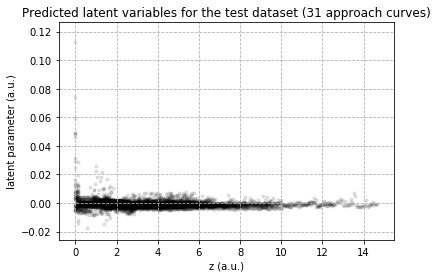

In [19]:
fig, ax = plt.subplots(1,1)

for i in range(test_dataset['Q'].size):
    imin = test_dataset['imin'][i]
    plot_index = range(imin+1)
    
    mech = test_dataset['mech'][i][plot_index, :]
    
    ww0 = np.ones((imin+1, 1))*test_dataset['w'][i]/test_dataset['w0'][i]
    Q = np.ones((imin+1, 1))*test_dataset['Q'][i]
    
    latent = encoder.predict([mech[:, 1:], np.c_[ww0,Q]], batch_size = batch_size)
    #latent = encoder.predict(np.c_[mech[:, 1:], ww0, Q], batch_size = batch_size)
    
    ax.scatter(mech[:,0], latent[0], c = 'k', marker = '.', alpha = 0.1) # plot amplitude
    

ax.grid(ls = '--')
ax.set_xlabel('z (a.u.)')
ax.set_ylabel('latent parameter (a.u.)')
ax.set_title('Predicted latent variables for the test dataset (31 approach curves)')

31


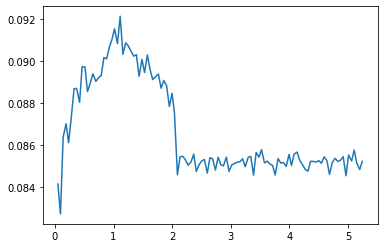

In [32]:
# Select particular approach curve
print(test_dataset['Q'].size)
trial_index = 25 # for anomaly, try 458
mech = test_dataset['mech'][trial_index]
imin = test_dataset['imin'][trial_index]
plot_index = range(imin)
plt.plot(mech[plot_index, 0], mech[plot_index, 2])
plt.show()

In [33]:
# calculate normalized k_int and b_int

k_i = test_dataset['kint'][trial_index][plot_index]
b_i = test_dataset['bint'][trial_index][plot_index]
E_i = test_dataset['E'][trial_index][plot_index]
Fk_i = test_dataset['Fk'][trial_index][plot_index]
Fb_i = test_dataset['Fb'][trial_index][plot_index]

ww0_i = np.ones((imin, 1))*test_dataset['w'][trial_index]/test_dataset['w0'][trial_index]
Q_i = np.ones((imin, 1))*test_dataset['Q'][trial_index]
#
latent = encoder.predict([mech[plot_index, 1:], np.c_[ww0_i, Q_i]], batch_size = batch_size)
reconstructed = model.predict([mech[plot_index, 1:], np.c_[ww0_i, Q_i]], batch_size = batch_size)
#latent = encoder.predict(mech[plot_index, 1:], batch_size = batch_size)

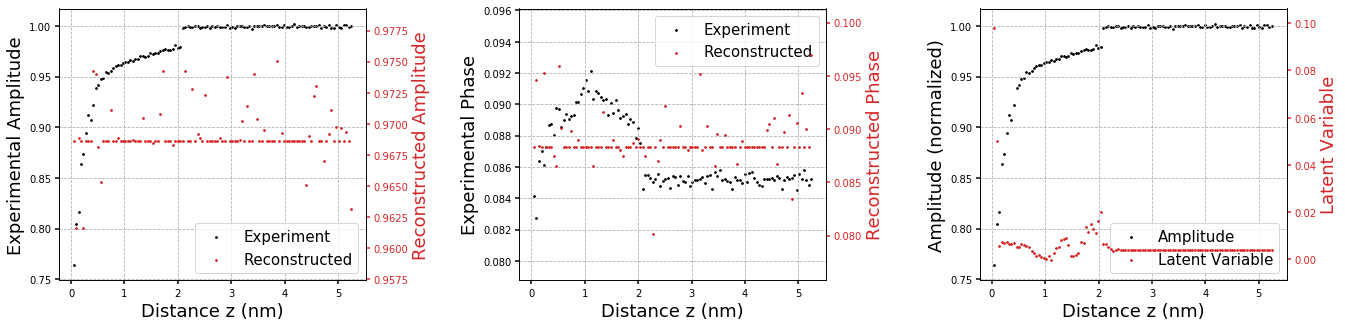

In [34]:
fig = plt.figure(figsize = (22, 5))
ax_l1 = fig.add_subplot(131)
ax_m1 = fig.add_subplot(132)
ax_r1 = fig.add_subplot(133)
fig.subplots_adjust(wspace = 0.5)

ax_l2 = ax_l1.twinx()
ax_m2 = ax_m1.twinx()
ax_r2 = ax_r1.twinx()

# Plot the data
line_l1 = ax_l1.scatter(mech[plot_index, 0], mech[plot_index, 1], s = 3, color = 'black', label = 'Experiment')
line_l2 = ax_l2.scatter(mech[plot_index, 0], reconstructed[:,0], s = 3, color = 'tab:red', label = 'Reconstructed')

line_m1 = ax_m1.scatter(mech[plot_index, 0], mech[plot_index, 2], s = 3, color = 'black', label = 'Experiment')
line_m2 = ax_m2.scatter(mech[plot_index, 0], reconstructed[:,1], s = 3, color = 'tab:red', label = 'Reconstructed')

line_r1 = ax_r1.scatter(mech[plot_index, 0], mech[plot_index, 1], s = 3, color = 'black', label = 'Amplitude')
line_r2 = ax_r2.scatter(mech[plot_index, 0], latent[0], s = 3, color = 'tab:red', label = 'Latent Variable')


# Set axis labels
fontsize = 18

ax_l1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_l1.set_ylabel('Experimental Amplitude', fontsize = fontsize)
ax_l2.set_ylabel('Reconstructed Amplitude', color = 'tab:red', fontsize = fontsize)

ax_m1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_m1.set_ylabel('Experimental Phase', fontsize = fontsize)
ax_m2.set_ylabel('Reconstructed Phase', color = 'tab:red', fontsize = fontsize)

ax_r1.set_xlabel('Distance z (nm)', fontsize = fontsize)
ax_r1.set_ylabel('Amplitude (normalized)', fontsize = fontsize)
ax_r2.set_ylabel('Latent Variable', color = 'tab:red', fontsize = fontsize)

# Set axis color and size
ax_l2.yaxis.label.set_color('tab:red')
ax_m2.yaxis.label.set_color('tab:red')
ax_r2.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)

ax_l1.tick_params(axis='x', **tkw)
ax_l1.tick_params(axis='y', **tkw)
ax_l2.tick_params(axis='y', colors='tab:red', **tkw)

ax_m1.tick_params(axis='x', **tkw)
ax_m1.tick_params(axis='y', **tkw)
ax_m2.tick_params(axis='y', colors='tab:red', **tkw)

ax_r1.tick_params(axis='x', **tkw)
ax_r1.tick_params(axis='y', **tkw)
ax_r2.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines_l = [line_l1, line_l2]
labels_l = [l.get_label() for l in lines_l]
ax_l1.legend(lines_l, labels_l, loc = 'best', fontsize = fontsize-3)

lines_m = [line_m1, line_m2]
labels_m = [l.get_label() for l in lines_m]
ax_m1.legend(lines_m, labels_m, loc = 'best', fontsize = fontsize-3)

lines_r = [line_r1, line_r2]
labels_r = [l.get_label() for l in lines_r]
ax_r1.legend(lines_r, labels_r, loc = 'best', fontsize = fontsize-3)

ax_l1.grid(ls = '--')
ax_m1.grid(ls = '--')
ax_r1.grid(ls = '--')

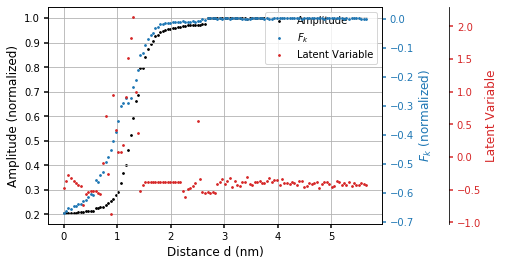

In [25]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
# Offset the right spine of par2.  The ticks and label have already been placed on the right by twinx above.
ax3.spines["right"].set_position(("axes", 1.2))
# Having been created by twinx, ax3 has its frame off, so the line of its detached spine is invisible.  
#First, activate the frame but make the patch and spines invisible.
make_patch_spines_invisible(ax3)
# Second, show the right spine.
ax3.spines["right"].set_visible(True)


# Plot the data
line1 = ax1.scatter(mech[plot_index, 0], mech[plot_index, 1], s = 3, color = 'black', label = 'Amplitude')
line2 = ax2.scatter(mech[plot_index, 0], 10000*Fk_i, s = 3, color = 'tab:blue', label = '$F_k$')
line3 = ax3.scatter(mech[plot_index, 0], 100*latent[0], s = 3, color = 'tab:red', label = 'Latent Variable')

# Set axis labels
ax1.set_xlabel('Distance d (nm)', fontsize = 12)
ax1.set_ylabel('Amplitude (normalized)', fontsize = 12)
ax2.set_ylabel('$F_k$ (normalized)', color = 'tab:blue', fontsize = 12)
ax3.set_ylabel('Latent Variable', color = 'tab:red', fontsize = 12)

# Set axis color and size
ax2.yaxis.label.set_color('tab:blue')
ax3.yaxis.label.set_color('tab:red')

tkw = dict(size = 4, width = 1.5)
ax1.tick_params(axis='x', **tkw)
ax1.tick_params(axis='y', **tkw)
ax2.tick_params(axis='y', colors='tab:blue', **tkw)
ax3.tick_params(axis='y', colors='tab:red', **tkw)

# Create unified legend for all the plots
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc = 'upper right')

#ax1.axvline(trial[np.argmax(latent),0], color = 'red', alpha = 0.8)
#ax1.axvline(trial[np.argmax(E_i),0], color = 'blue', alpha = 0.8)
ax1.grid(True)


In [35]:
from scipy.stats.stats import pearsonr
amp = np.reshape(mech[plot_index, 1], mech[plot_index, 2].size)
phas = np.reshape(mech[plot_index, 2], mech[plot_index, 2].size)
latent_var = np.reshape(latent[0], mech[plot_index, 2].size)

pearsonr(amp, latent_var)
pearsonr(phas, latent_var)

(0.45677784858776815, 1.5720093242374292e-07)

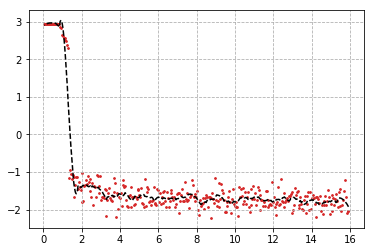

In [82]:
from scipy.signal import savgol_filter
y = np.ravel(latent[0])

trend = savgol_filter(y, 21, 2)
slope = savgol_filter(y, 21, 2, deriv = 1)
fig, ax = plt.subplots()
ax.scatter(mech[plot_index, 0], latent[0], s = 3, color = 'tab:red', label = 'Latent Variable')
ax.plot(mech[plot_index, 0], trend, '--k', label = 'Latent Trend')
ax.grid(ls = '--')

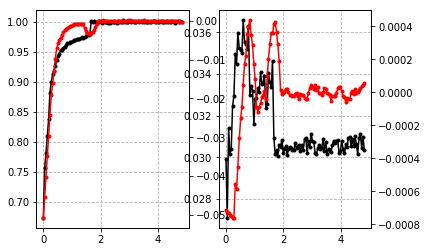

In [22]:
from scipy.signal import savgol_filter

amp = np.reshape(mech[plot_index, 1], mech[plot_index, 2].size)
phas = np.reshape(mech[plot_index, 2], mech[plot_index, 2].size)

d_amp = savgol_filter(amp, 11, 2, deriv = 1)
d_phas = savgol_filter(phas, 11, 2, deriv = 1)

fig, axes = plt.subplots(1,2)
axes = axes.flatten()

axes[0].plot(mech[plot_index, 0], amp, '.-k',label = 'Amplitude')
ax0 = axes[0].twinx()
ax0.plot(mech[plot_index, 0], d_amp, '.-r',label = 'Amplitude Slope')

axes[1].plot(mech[plot_index, 0], phas, '.-k',label = 'Phase')
ax1 = axes[1].twinx()
ax1.plot(mech[plot_index, 0], d_phas, '.-r',label = 'Phase Slope')

for ax in axes:
    ax.grid(ls = '--')

0.12720096


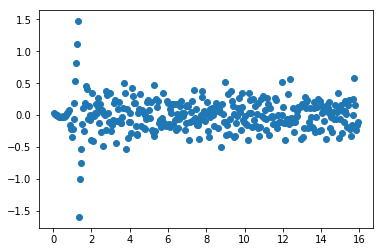

In [83]:
plt.scatter(mech[plot_index, 0], y-trend)
print(np.std(y-trend)/np.abs(y[0]))

C:\Users\user\Anaconda3\envs\DL_GPU\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


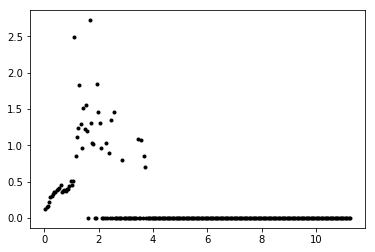

In [30]:
tau = Fk_i/Fb_i
tau_index = Fb_i < 3e-7
tau[tau_index] = 0
plt.plot(mech[plot_index, 0], tau, '.k')

In [30]:
path = 'C:\\Users\\user\\OneDrive - SNU\\Jhe Lab\\Projects\\Current\\1. AFM Contact Point Detection\\Raw Data_Me\\'
filename = '0904ApproachCurve1.txt'
filepath = path + filename
    
z_test = [] # raw z data in bits
amp_test = [] # raw amp data in V
phas_test = [] # raw phase data in V
    
# fast file import using "with"
# unlike np.loadtxt, which loads the entire file into memory before importing, this reads data line by line into memory
with open(filepath) as file:
    for index, line in enumerate(file):
        if index == 0:
            header = line
                
        else:
            word_list = line.split('\t')
                
            z_test.append(float(word_list[0]))
            amp_test.append(float(word_list[1]))
            phas_test.append(float(word_list[2]))
                
 # Convert numpy arrays    
z_test = np.array(z_test)
amp_test = np.array(amp_test)
phas_test = np.array(phas_test)
        
# Preprocess data
z_test = z_test - z_test[0]
amp_test = amp_test/amp_test[0]
phas_test = (phas_test - phas_test[0])*np.pi/10

# Discard NaN
nan_index = np.logical_or(np.isnan(amp_test), np.isnan(phas_test))
z_test = z_test[~nan_index]
amp_test = amp_test[~nan_index]
phas_test = phas_test[~nan_index]
    
# Discard retraction part
z_min_index = np.argmin(z_test)
z_test = z_test[:z_min_index+1]
amp_test = amp_test[:z_min_index+1]
phas_test = phas_test[:z_min_index+1]

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\user\\OneDrive - SNU\\Jhe Lab\\Projects\\Current\\1. AFM Contact Point Detection\\Raw Data_Me\\0904ApproachCurve1.txt'

In [23]:
latent = encoder.predict(np.c_[amp_test, phas_test], batch_size = batch_size)

E_dis_test = np.pi*(F*amp_test*np.cos(phas_test) - b*w*np.power(amp_test, 2))

In [ ]:
# First, we search the network structure space -  that is, n_layer, n_node, dropout_rate, batch_normalization
n_hidden = [1, 2, 3, 4, 5]
n_node = [8, 16, 32, 64, 128]
#dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
#batch_normalization = [True, False]
batch_size = 64
epochs = 100

loss = np.empty((len(n_hidden), len(n_node)))
val_loss = np.empty((len(n_hidden), len(n_node)))

for i in range(len(n_hidden)):
    for j in range(len(n_node)):
        # Generate the model with the given hyperparameters
        current_vae = CreateVAE(n_hidden = n_hidden[i], n_node = n_node[j])
        current_model = current_vae['model']
        current_encoder = current_vae['encoder']
        current_decoder = current_vae['decoder']
        
        # Fit the created model
        stop_callback = EarlyStopping(monitor = 'val_loss', min_delta = 500, patience = 3) # loss change of under min_delta count as no improvement
        current_history = current_model.fit(x = train[:, 1:], epochs = epochs, batch_size = batch_size, validation_data = (test[:, 1:], None), callbacks = [stop_callback])
        
        loss[i,j] = current_history.history['loss'][-1]
        val_loss[i,j] = current_history.history['val_loss'][-1]

